In [1]:
import pandas as pd
import numpy as np
import sklearn as sl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
print(pd.__version__)

2.3.1


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
print(df.shape)
print(df.describe)

(1462, 9)
<bound method NDFrame.describe of          lead_source       industry  number_of_courses_viewed  annual_income  \
0           paid_ads            NaN                         1        79450.0   
1       social_media         retail                         1        46992.0   
2             events     healthcare                         5        78796.0   
3           paid_ads         retail                         2        83843.0   
4           referral      education                         3        85012.0   
...              ...            ...                       ...            ...   
1457        referral  manufacturing                         1            NaN   
1458        referral     technology                         3        65259.0   
1459        paid_ads     technology                         1        45688.0   
1460        referral            NaN                         5        71016.0   
1461  organic_search        finance                         3        92855.0

In [5]:
for i in df:
    print([i])
    print(df[i].head().unique())
    print(df[i].nunique())

['lead_source']
['paid_ads' 'social_media' 'events' 'referral']
5
['industry']
[nan 'retail' 'healthcare' 'education']
7
['number_of_courses_viewed']
[1 5 2 3]
10
['annual_income']
[79450. 46992. 78796. 83843. 85012.]
1267
['employment_status']
['unemployed' 'employed' nan 'self_employed']
4
['location']
['south_america' 'australia' 'europe']
7
['interaction_count']
[4 1 3]
12
['lead_score']
[0.94 0.8  0.69 0.87 0.62]
101
['converted']
[1 0]
2


In [6]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [7]:
for i in df:
   if df[i].dtypes == 'object':
       df[i] = df[i].fillna('NA')
   else:
       df[i]= df[i].fillna(0)


In [8]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [9]:
df.converted.value_counts(normalize=True) # conversion rate

converted
1    0.619015
0    0.380985
Name: proportion, dtype: float64

In [10]:
global_conversion_rate = df.converted.mean()
round(global_conversion_rate,2)

np.float64(0.62)

In [11]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)

In [12]:
df_train, df_val = train_test_split( df_full_train, test_size = 0.25, random_state = 1)

In [13]:
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)

In [14]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [15]:
del df_train["converted"]
del df_val["converted"]
del df_test["converted"]

In [16]:
dv = DictVectorizer(sparse = False)

In [17]:
train_dicts = df_train[['lead_source','industry','employment_status','location','number_of_courses_viewed','interaction_count']].to_dict(orient = 'records')
train_dicts[0]

{'lead_source': 'events',
 'industry': 'manufacturing',
 'employment_status': 'unemployed',
 'location': 'europe',
 'number_of_courses_viewed': 2,
 'interaction_count': 3}

In [18]:
dv.fit(train_dicts)

,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True


In [19]:
dv.get_feature_names_out(train_dicts)

array(['employment_status=NA', 'employment_status=employed',
       'employment_status=self_employed', 'employment_status=student',
       'employment_status=unemployed', 'industry=NA',
       'industry=education', 'industry=finance', 'industry=healthcare',
       'industry=manufacturing', 'industry=other', 'industry=retail',
       'industry=technology', 'interaction_count', 'lead_source=NA',
       'lead_source=events', 'lead_source=organic_search',
       'lead_source=paid_ads', 'lead_source=referral',
       'lead_source=social_media', 'location=NA', 'location=africa',
       'location=asia', 'location=australia', 'location=europe',
       'location=middle_east', 'location=north_america',
       'location=south_america', 'number_of_courses_viewed'], dtype=object)

In [20]:
dv.transform(train_dicts)

array([[0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 2.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(876, 29))

In [21]:
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[['lead_source','industry','employment_status','location','number_of_courses_viewed','interaction_count']].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

In [22]:
model = LogisticRegression()
model.fit(X_train, y_train)
model.coef_[0].round(3)

array([-4.500e-01,  8.110e-01,  2.440e-01,  2.260e-01, -8.280e-01,
       -4.300e-01,  9.070e-01,  1.550e-01, -3.300e-01, -1.000e-03,
       -2.340e-01, -7.300e-02,  8.000e-03,  9.830e-01,  6.500e-02,
       -8.800e-02, -9.400e-02, -1.149e+00,  1.358e+00, -8.900e-02,
        2.230e-01, -1.980e-01, -1.880e-01, -1.060e-01,  2.060e-01,
        4.000e-03, -3.320e-01,  3.950e-01,  1.356e+00])

In [23]:
len(X_train), len(X_val)

(876, 293)

In [24]:
# hard prediction
#model.predict(X_train)
# soft prediction
#model.predict_proba(X_train)

In [25]:
model.predict(X_val)

array([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1])

In [26]:
y_pred = model.predict(X_val)

In [27]:
len(y_pred),len(y_val)

(293, 293)

In [28]:
dict(zip(dv.get_feature_names_out(),model.coef_[0].round(3)))

{'employment_status=NA': np.float64(-0.45),
 'employment_status=employed': np.float64(0.811),
 'employment_status=self_employed': np.float64(0.244),
 'employment_status=student': np.float64(0.226),
 'employment_status=unemployed': np.float64(-0.828),
 'industry=NA': np.float64(-0.43),
 'industry=education': np.float64(0.907),
 'industry=finance': np.float64(0.155),
 'industry=healthcare': np.float64(-0.33),
 'industry=manufacturing': np.float64(-0.001),
 'industry=other': np.float64(-0.234),
 'industry=retail': np.float64(-0.073),
 'industry=technology': np.float64(0.008),
 'interaction_count': np.float64(0.983),
 'lead_source=NA': np.float64(0.065),
 'lead_source=events': np.float64(-0.088),
 'lead_source=organic_search': np.float64(-0.094),
 'lead_source=paid_ads': np.float64(-1.149),
 'lead_source=referral': np.float64(1.358),
 'lead_source=social_media': np.float64(-0.089),
 'location=NA': np.float64(0.223),
 'location=africa': np.float64(-0.198),
 'location=asia': np.float64(-0.18

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
accuracy_score(y_val, y_pred >= 0.5)

0.8293515358361775

In [31]:
from collections import Counter

In [32]:
Counter(y_pred >= 1)

Counter({np.True_: 181, np.False_: 112})

In [33]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [34]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [35]:
tp = (predict_positive & actual_positive).sum()
tn = (actual_negative & predict_negative).sum()

In [36]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [37]:
confusion_matrix = np.array([[tn, fp], [fn, tp]])
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.31, 0.1 ],
       [0.07, 0.52]])

In [38]:
# precision: how many positive predictions are correct
p = tp / (tp + fp)
(1 - p).round(2)  # 17% of carts won't be converted but

np.float64(0.17)

In [39]:
# recall: all relevant positive cases
r = tp/ (tp + fn)
(1 - r).round(2) # 12% failed to identify

np.float64(0.12)

In [40]:
# ROC curve is a way to measure model performance 
from sklearn.metrics import roc_curve

In [41]:
fpr, tpr, thresholds = roc_curve(y_val,y_pred)

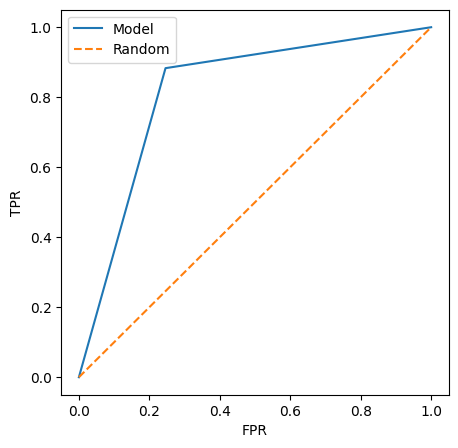

In [42]:
plt.figure(figsize = (5, 5))

plt.plot(fpr, tpr, label = 'Model')
plt.plot([0, 1], [0, 1], label = 'Random', linestyle = '--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [43]:
from sklearn.metrics import auc

In [44]:
auc(fpr,tpr)

0.8185696481641261

In [45]:
from sklearn.metrics import roc_auc_score

In [46]:
len(y_val), len(y_pred)

(293, 293)

In [47]:
roc_auc_score(y_val, y_pred)

0.8185696481641261

In [48]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [49]:
import random

In [50]:
# how well our model separates negative and positive classes
n =1000000
success = 0
for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1
success / n
#- A value of 0.89 suggests that your model can distinguish between positive and negative classes 80% of the time — a strong signal of good separability.


0.665716

In [51]:
n =1000000
pos_ind =  np.random.randint(0, len(pos), size = n)
neg_ind =  np.random.randint(0, len(neg), size = n)

In [52]:
(pos[pos_ind] > neg[neg_ind]).mean()  # the mean of this array is the AUC

np.float64(0.665718)

In [53]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient = 'records')

    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model


In [54]:
print(f"y_val shape: {y_val.shape}, y_pred shape: {y_pred.shape}")

y_val shape: (293,), y_pred shape: (293,)


In [55]:
def predict(df, dv, model):
    dicts = df_val.to_dict(orient = 'records')

    x = dv.fit_transform(dicts)
    y_pred = model.predict_proba(x)[:,1]

    return y_pred


In [56]:
from sklearn.model_selection import KFold

In [57]:
kfold = KFold(n_splits = 10, shuffle = True, random_state=1)
train_idx, val_idx = next(kfold.split(df_full_train))

In [58]:
#!pip install tqdm <- this package can show how long each iteration take in a loop

In [59]:
from tqdm.auto import tqdm

In [60]:
n_splits = 5
for C in tqdm([ 0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = []    
    kfold = KFold(n_splits = n_splits, shuffle = True, random_state = 1)

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.converted.values
        y_val = df_val.converted.values
    
        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('%s %.3d +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

0.001 001 +- 0.000
0.01 001 +- 0.000
0.1 001 +- 0.000
0.5 001 +- 0.000
1 001 +- 0.000
5 001 +- 0.000
10 001 +- 0.000


In [61]:
# train the final model
dv, model = train(df_train, y_train, C=1.0)
y_pred = predict(df_test, dv, model)
    
auc = roc_auc_score(y_val, y_pred)
auc

1.0

In [62]:
C_values = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]
best_C = None
best_score = 0

for C in tqdm(C_values):
    scores = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    mean_score = np.mean(scores)
    print(f"C={C}, AUC={mean_score:.4f}")

    if mean_score > best_score:
        best_score = mean_score
        best_C = C

print(f"\nBest C: {best_C} with AUC: {best_score:.4f}")

  0%|          | 0/9 [00:00<?, ?it/s]

C=0.001, AUC=1.0000
C=0.01, AUC=1.0000
C=0.1, AUC=1.0000
C=0.5, AUC=1.0000
C=1, AUC=1.0000
C=5, AUC=1.0000
C=10, AUC=1.0000
C=50, AUC=1.0000
C=100, AUC=1.0000

Best C: 0.001 with AUC: 1.0000


In [63]:
#Q1
auc_lead_score = roc_auc_score(df['converted'], df['lead_score'])
auc_annual_income = roc_auc_score(df['converted'], df['annual_income'])
auc_interaction_count = roc_auc_score(df['converted'], df['interaction_count'])
auc_number_of_courses_viewed = roc_auc_score(df['converted'], df['number_of_courses_viewed'])
print(auc_lead_score,auc_annual_income,auc_interaction_count,auc_number_of_courses_viewed)

0.6148050428003213 0.5426406260848865 0.7223206403681919 0.7608270430582144


In [64]:
#Q2
X_train_full_q2 = df_train[['lead_score','annual_income','interaction_count','number_of_courses_viewed','converted']]
train_dicts_q2 = df_train[['lead_score','annual_income','interaction_count','number_of_courses_viewed']].to_dict(orient = 'records')
train_dicts_q2[0]

{'lead_score': 0.75,
 'annual_income': 56659.0,
 'interaction_count': 4,
 'number_of_courses_viewed': 1}

In [65]:
X_val_set_q2 = df_val[['lead_score','annual_income','interaction_count','number_of_courses_viewed','converted']]
val_dicts_q2 = df_val[['lead_score','annual_income','interaction_count','number_of_courses_viewed']].to_dict(orient = 'records')
val_dicts_q2[0]

{'lead_score': 0.11,
 'annual_income': 67877.0,
 'interaction_count': 3,
 'number_of_courses_viewed': 3}

In [66]:
X_train_q2 = dv.fit_transform(train_dicts_q2)
X_val_q2 = dv.fit_transform(val_dicts_q2)

In [67]:
y_train_q2 = X_train_full_q2.converted.values
y_val_q2 = X_val_set_q2.converted.values

In [68]:
q2_model =LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_q2, y_train_q2)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [69]:
y_pred_q2 = model.predict(X_val_q2)

In [74]:
round(roc_auc_score(y_val_q2,y_pred_q2),3)

0.86